# SMT vs Non-SMT Comparison

This notebook demonstrates how to compare SMT-enabled vs non-SMT processor configurations
at the same oversubscription ratio.

**Use Case**: You want to understand the carbon and TCO implications of disabling SMT
on your server fleet while keeping the same oversubscription policy.

In [1]:
import sys
sys.path.insert(0, '..')

from smt_oversub_model import (
    compare_smt_vs_nosmt,
    compare_oversub_ratios,
    ScenarioBuilder,
    plot_scenarios,
    polynomial_power_curve_fn
)

## Basic Comparison: SMT vs Non-SMT at No Oversubscription

Compare what happens when you disable SMT on your fleet while maintaining R=1.0 (no oversubscription).

In [ ]:
# Compare SMT vs Non-SMT at R=1.0 (no oversubscription)
curve_fn = polynomial_power_curve_fn(freq_mhz=3500)
result = compare_smt_vs_nosmt(
    total_vcpus=10000,      # Total vCPU demand
    oversub_ratio=1.0,      # No oversubscription
    avg_util=0.3,           # 30% average utilization
    smt_physical_cores=84,
    nosmt_physical_cores=96,
    smt_power_idle_w=300.0,
    smt_power_max_w=800.0,
    nosmt_power_ratio=1.0,
    nosmt_idle_ratio=1.0,
    smt_thread_overhead=8,
    nosmt_thread_overhead=9,
    carbon_intensity_g_kwh=200.0,
    embodied_carbon_kg=4000.0,
    server_cost_usd=10000.0,
    electricity_cost_usd_kwh=0.28,
    lifetime_years=6.0,
    power_curve_fn=curve_fn,
)
# Some values from /Users/jaylenw/Code/frugal-model/savings_v2.ipynb

# Display results
print("=" * 60)
print("SMT vs Non-SMT Comparison (R=1.0, No Oversubscription)")
print("=" * 60)
print(f"\nWorkload: {result['summary']['total_vcpus']} vCPUs @ {result['summary']['avg_util']:.0%} avg utilization")
print(f"Lifetime: {result['summary']['lifetime_years']:.0f} years\n")

for scenario in result['scenarios']:
    print(f"--- {scenario['name']} ---")
    print(f"  Servers: {scenario['num_servers']}")
    print(f"  Total Carbon: {scenario['total_carbon_kg']:,.0f} kg CO2e")
    print(f"  Total TCO: ${scenario['total_cost_usd']:,.0f}")
    print()

In [3]:
# Show the comparison metrics
print("\nComparison vs SMT baseline:")
for name, comp in result['comparisons'].items():
    print(f"\n{name}:")
    print(f"  Carbon: {comp['carbon_diff_pct']:+.1f}% ({comp['carbon_diff_abs']:+,.0f} kg)")
    print(f"  TCO: {comp['tco_diff_pct']:+.1f}% (${comp['tco_diff_abs']:+,.0f})")
    print(f"  Servers: {comp['server_diff_pct']:+.1f}% ({comp['server_diff_abs']:+.0f})")


Comparison vs SMT baseline:

Non-SMT:
  Carbon: +82.8% (+602,588 kg)
  TCO: +82.8% ($+1,072,423)
  Servers: +82.5% (+52)


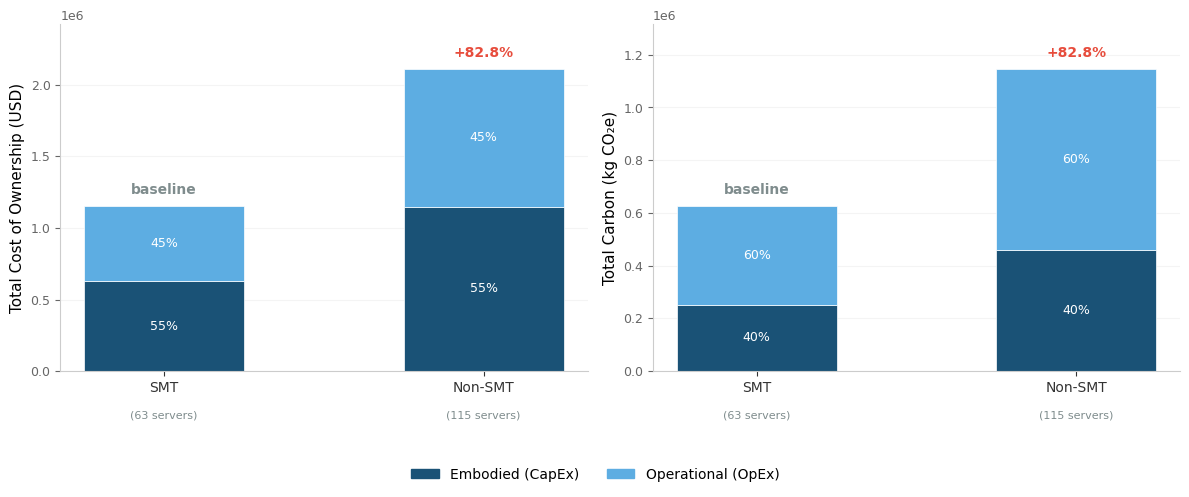

In [6]:
# Visualize the comparison
fig = plot_scenarios(
    result['scenarios'],
    baseline_idx=0,
    show=True,
)

## Sensitivity Analysis: Different Utilization Levels

Let's see how the comparison changes at different average utilization levels.

In [5]:
import pandas as pd

# Compare across different utilization levels
utilization_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
results_by_util = []

for util in utilization_levels:
    result = compare_smt_vs_nosmt(
        total_vcpus=10000,
        oversub_ratio=1.0,
        avg_util=util,
    )
    
    nosmt_comp = result['comparisons']['Non-SMT']
    results_by_util.append({
        'Utilization': f"{util:.0%}",
        'SMT Servers': result['scenarios'][0]['num_servers'],
        'Non-SMT Servers': result['scenarios'][1]['num_servers'],
        'Carbon Impact (%)': nosmt_comp['carbon_diff_pct'],
        'TCO Impact (%)': nosmt_comp['tco_diff_pct'],
    })

df = pd.DataFrame(results_by_util)
print("Impact of Disabling SMT at Different Utilization Levels (R=1.0)")
print("=" * 70)
print(df.to_string(index=False))

Impact of Disabling SMT at Different Utilization Levels (R=1.0)
Utilization  SMT Servers  Non-SMT Servers  Carbon Impact (%)  TCO Impact (%)
        10%          105              209          83.236217       97.823268
        20%          105              209          80.959494       97.443645
        30%          105              209          79.232850       97.073161
        40%          105              209          77.878416       96.711490
        50%          105              209          76.787546       96.358322
        60%          105              209          75.890131       96.013360


## Custom Scenario: Comparing Oversubscription Strategies

Let's compare:
1. SMT at R=1.0 (baseline)
2. Non-SMT at R=1.0
3. SMT at R=1.3 (with oversubscription)
4. Non-SMT at R=1.3

In [6]:
from smt_oversub_model import ScenarioBuilder, ProcessorDefaults, CostDefaults, compare_scenarios

# Create builder with defaults
builder = ScenarioBuilder()

# Define scenarios
scenarios = [
    builder.build_scenario("SMT R=1.0", smt=True, oversub_ratio=1.0),
    builder.build_scenario("Non-SMT R=1.0", smt=False, oversub_ratio=1.0),
    builder.build_scenario("SMT R=1.3", smt=True, oversub_ratio=1.3, util_overhead=0.05),
    builder.build_scenario("Non-SMT R=1.3", smt=False, oversub_ratio=1.3, util_overhead=0.05),
]

# Build workload and cost params
workload = builder.build_workload_params(total_vcpus=10000, avg_util=0.3)
cost = builder.build_cost_params()

# Compare all scenarios
result = compare_scenarios(scenarios, workload, cost, baseline_idx=0)

# Display
print("Multi-Scenario Comparison")
print("=" * 70)
for s in result['scenarios']:
    print(f"\n{s['name']}:")
    print(f"  Servers: {s['num_servers']}")
    print(f"  Carbon: {s['total_carbon_kg']:,.0f} kg")
    print(f"  TCO: ${s['total_cost_usd']:,.0f}")

Multi-Scenario Comparison

SMT R=1.0:
  Servers: 105
  Carbon: 453,210 kg
  TCO: $1,137,052

Non-SMT R=1.0:
  Servers: 209
  Carbon: 812,301 kg
  TCO: $2,240,825

SMT R=1.3:
  Servers: 81
  Carbon: 408,449 kg
  TCO: $891,862

Non-SMT R=1.3:
  Servers: 161
  Carbon: 723,874 kg
  TCO: $1,750,718


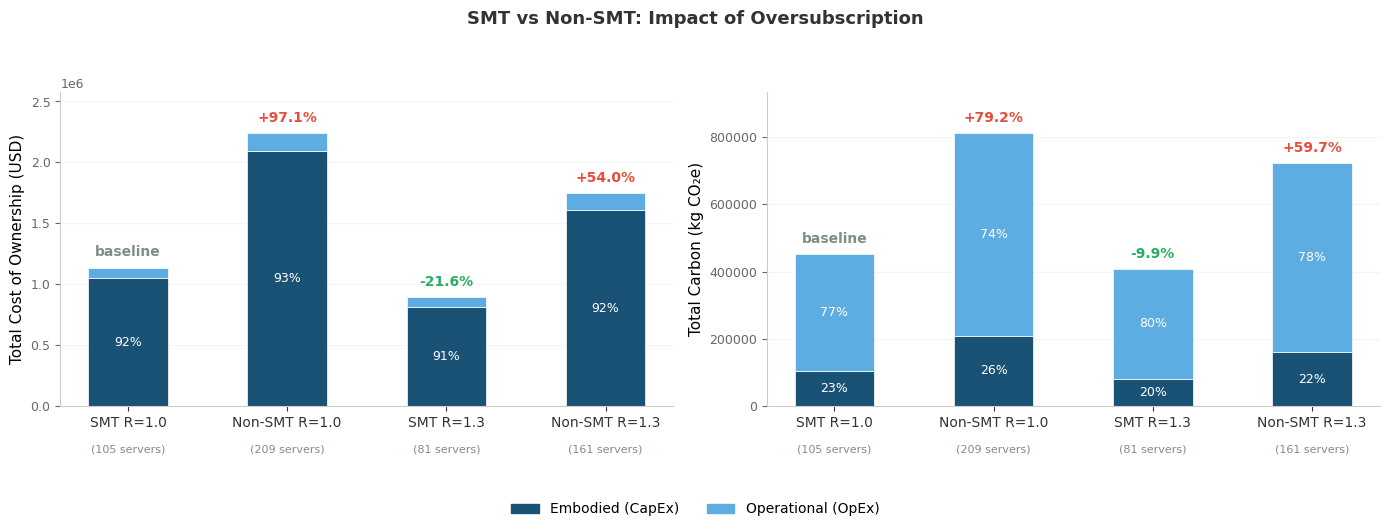

In [7]:
# Visualize all four scenarios
fig = plot_scenarios(
    result['scenarios'],
    baseline_idx=0,
    title="SMT vs Non-SMT: Impact of Oversubscription",
    figsize=(14, 5),
    show=True,
)

## Advanced: Custom Processor Configurations

You can customize processor and cost parameters for your specific hardware.

In [8]:
# Custom configuration for a specific server type
result = compare_smt_vs_nosmt(
    total_vcpus=50000,
    oversub_ratio=1.0,
    avg_util=0.25,
    
    # Custom processor specs
    smt_physical_cores=64,           # 64-core processor
    nosmt_physical_cores=64,
    smt_power_idle_w=150.0,          # Higher idle power
    smt_power_max_w=500.0,           # Higher max power
    nosmt_power_ratio=0.80,          # Non-SMT uses 80% of SMT max power
    nosmt_idle_ratio=0.85,           # Non-SMT uses 85% of SMT idle power
    
    # Custom cost parameters
    embodied_carbon_kg=1500.0,       # More embodied carbon per server
    server_cost_usd=15000.0,         # Higher server cost
    carbon_intensity_g_kwh=300.0,    # Cleaner grid (300g/kWh)
    electricity_cost_usd_kwh=0.08,   # Cheaper electricity
    lifetime_years=4.0,              # 4-year refresh cycle
)

print("Custom Configuration Results")
print("=" * 60)
for s in result['scenarios']:
    print(f"\n{s['name']}:")
    print(f"  Servers: {s['num_servers']}")
    print(f"  Embodied Carbon: {s['embodied_carbon_kg']:,.0f} kg")
    print(f"  Operational Carbon: {s['operational_carbon_kg']:,.0f} kg")
    print(f"  Total Carbon: {s['total_carbon_kg']:,.0f} kg")

Custom Configuration Results

SMT:
  Servers: 391
  Embodied Carbon: 586,500 kg
  Operational Carbon: 975,826 kg
  Total Carbon: 1,562,326 kg

Non-SMT:
  Servers: 782
  Embodied Carbon: 1,173,000 kg
  Operational Carbon: 1,607,576 kg
  Total Carbon: 2,780,576 kg


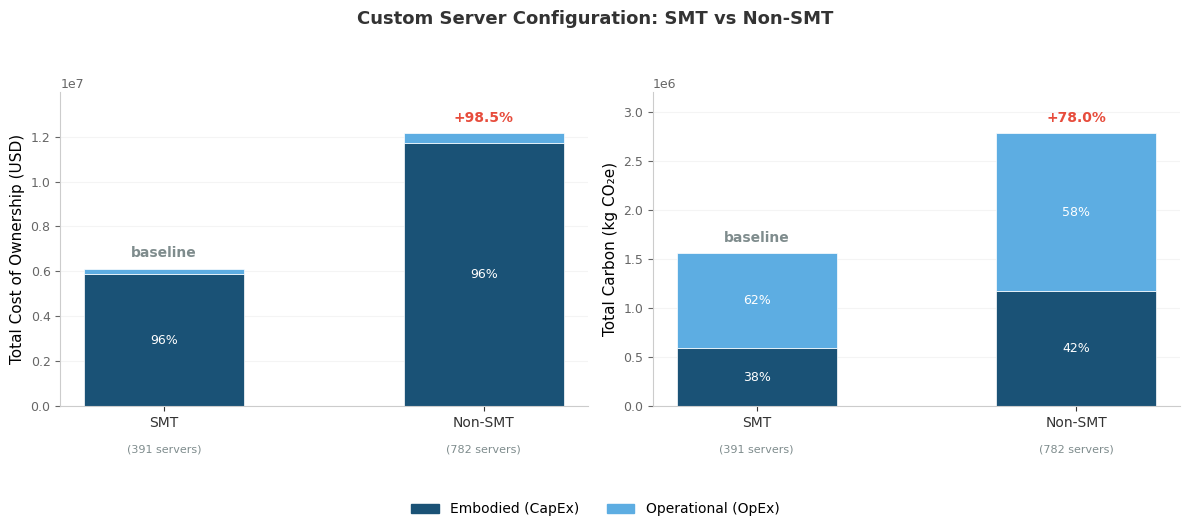

In [9]:
# Plot the custom comparison
fig = plot_scenarios(
    result['scenarios'],
    baseline_idx=0,
    title="Custom Server Configuration: SMT vs Non-SMT",
    show=True,
)

## Comparing Different Oversubscription Ratios

Use `compare_oversub_ratios` to see how different R values affect a single processor type.

In [10]:
# Compare different oversubscription ratios for SMT
result = compare_oversub_ratios(
    total_vcpus=10000,
    oversub_ratios=[1.0, 1.2, 1.4, 1.6],
    smt=True,
    avg_util=0.3,
    util_overhead=0.05,  # 5% overhead per scenario
)

print("SMT: Impact of Oversubscription Ratio")
print("=" * 60)
for s in result['scenarios']:
    print(f"\n{s['name']}:")
    print(f"  Servers: {s['num_servers']}")
    print(f"  Carbon: {s['total_carbon_kg']:,.0f} kg")
    print(f"  TCO: ${s['total_cost_usd']:,.0f}")

SMT: Impact of Oversubscription Ratio

SMT R=1.0:
  Servers: 105
  Carbon: 480,804 kg
  TCO: $1,143,951

SMT R=1.2:
  Servers: 87
  Carbon: 426,538 kg
  TCO: $954,884

SMT R=1.4:
  Servers: 75
  Carbon: 390,360 kg
  TCO: $828,840

SMT R=1.6:
  Servers: 66
  Carbon: 363,227 kg
  TCO: $734,307


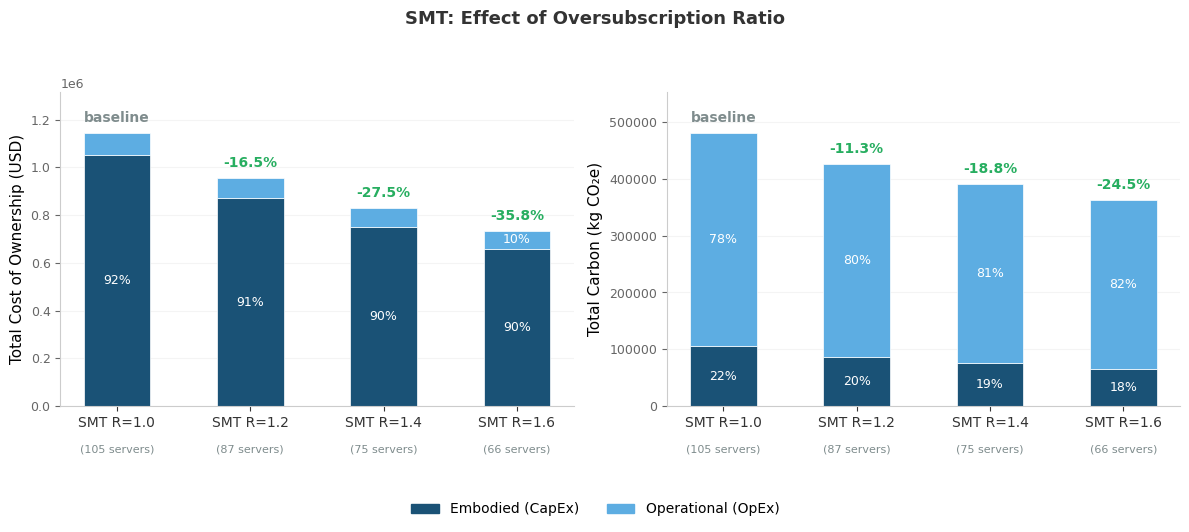

In [11]:
# Visualize
fig = plot_scenarios(
    result['scenarios'],
    baseline_idx=0,
    title="SMT: Effect of Oversubscription Ratio",
    show=True,
)

## Summary (Basic Analysis)

The sections above demonstrated:

1. **Basic SMT vs Non-SMT comparison** at the same oversubscription ratio
2. **Sensitivity analysis** across different utilization levels  
3. **Multi-scenario comparisons** combining SMT/non-SMT with different R values
4. **Custom configurations** for specific hardware profiles
5. **Oversubscription ratio sweeps** for a single processor type

The `compare_smt_vs_nosmt()` function is the simplest entry point for quick comparisons.
For more flexibility, use `ScenarioBuilder` and `compare_scenarios()` directly.

## Oversubscription Savings Sweep: Actual vs Theoretical

This analysis shows how carbon and TCO savings scale with oversubscription ratio for SMT.

**Theoretical savings** assume a perfectly linear relationship: if you oversub by R, you need 1/R servers.
- At R=2.0: theoretical = 50% (half the servers)
- At R=1.5: theoretical = 33.3%
- At R=1.2: theoretical = 16.7%

**Actual savings** may differ due to:
- Power consumption doesn't scale linearly with utilization
- Ceiling effects when calculating server counts
- Embodied vs operational carbon mix

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_oversub_savings_sweep(
    total_vcpus: int = 10000,
    avg_util: float = 0.3,
    oversub_min: float = 1.0,
    oversub_max: float = 2.0,
    step: float = 0.1,
    util_overhead: float = 0.0,
    smt: bool = True,
    **kwargs,
):
    """
    Compute actual and theoretical savings for a sweep of oversubscription ratios.
    
    Returns:
        dict with 'ratios', 'carbon_savings_pct', 'tco_savings_pct', 'theoretical_savings_pct'
    """
    ratios = np.arange(oversub_min, oversub_max + step/2, step)
    
    # Create builder
    builder = ScenarioBuilder()
    workload = builder.build_workload_params(total_vcpus, avg_util)
    cost = builder.build_cost_params(**kwargs)
    
    # Get baseline (R=1.0)
    baseline_scenario = builder.build_scenario(
        name="Baseline",
        smt=smt,
        oversub_ratio=1.0,
        util_overhead=0.0,  # No overhead at baseline
    )
    from smt_oversub_model.analysis import evaluate_scenarios
    baseline_result = evaluate_scenarios([baseline_scenario], workload, cost)[0]
    
    baseline_carbon = baseline_result['total_carbon_kg']
    baseline_tco = baseline_result['total_cost_usd']
    
    # Compute savings for each ratio
    carbon_savings = []
    tco_savings = []
    theoretical_savings = []
    
    for r in ratios:
        # Theoretical: 1 - 1/R (perfect linear server reduction)
        theoretical = (1 - 1/r) * 100
        theoretical_savings.append(theoretical)
        
        # Actual
        scenario = builder.build_scenario(
            name=f"R={r:.1f}",
            smt=smt,
            oversub_ratio=r,
            util_overhead=util_overhead if r > 1.0 else 0.0,
        )
        result = evaluate_scenarios([scenario], workload, cost)[0]
        
        carbon_pct = (1 - result['total_carbon_kg'] / baseline_carbon) * 100
        tco_pct = (1 - result['total_cost_usd'] / baseline_tco) * 100
        
        carbon_savings.append(carbon_pct)
        tco_savings.append(tco_pct)
    
    return {
        'ratios': ratios,
        'carbon_savings_pct': np.array(carbon_savings),
        'tco_savings_pct': np.array(tco_savings),
        'theoretical_savings_pct': np.array(theoretical_savings),
    }

In [8]:
def plot_oversub_savings_sweep(sweep_result, title_suffix=""):
    """
    Plot carbon and TCO savings vs oversubscription ratio.
    
    Creates two side-by-side plots showing actual vs theoretical savings.
    """
    ratios = sweep_result['ratios']
    carbon = sweep_result['carbon_savings_pct']
    tco = sweep_result['tco_savings_pct']
    theoretical = sweep_result['theoretical_savings_pct']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Carbon savings plot
    ax1 = axes[0]
    ax1.plot(ratios, carbon, 'b-o', linewidth=2, markersize=6, label='Actual Carbon Savings')
    ax1.plot(ratios, theoretical, 'k--', linewidth=2, alpha=0.7, label='Theoretical (1 - 1/R)')
    ax1.set_xlabel('Oversubscription Ratio (R)', fontsize=12)
    ax1.set_ylabel('Carbon Savings (%)', fontsize=12)
    ax1.set_title(f'Carbon Savings vs Oversubscription{title_suffix}', fontsize=14)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(ratios[0], ratios[-1])
    ax1.set_ylim(bottom=0)
    
    # TCO savings plot
    ax2 = axes[1]
    ax2.plot(ratios, tco, 'g-o', linewidth=2, markersize=6, label='Actual TCO Savings')
    ax2.plot(ratios, theoretical, 'k--', linewidth=2, alpha=0.7, label='Theoretical (1 - 1/R)')
    ax2.set_xlabel('Oversubscription Ratio (R)', fontsize=12)
    ax2.set_ylabel('TCO Savings (%)', fontsize=12)
    ax2.set_title(f'TCO Savings vs Oversubscription{title_suffix}', fontsize=14)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(ratios[0], ratios[-1])
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [9]:
# Run the sweep with default parameters (SMT, no utilization overhead)
sweep = compute_oversub_savings_sweep(
    total_vcpus=10000,
    avg_util=0.3,
    oversub_min=1.0,
    oversub_max=2.0,
    step=0.1,
    util_overhead=0.0,  # No additional overhead
    smt=True,
)

# Print the data
print("Oversubscription Savings Analysis (SMT)")
print("=" * 60)
print(f"{'Ratio':<8} {'Carbon %':<12} {'TCO %':<12} {'Theoretical %':<12}")
print("-" * 60)
for i, r in enumerate(sweep['ratios']):
    print(f"{r:<8.1f} {sweep['carbon_savings_pct'][i]:<12.1f} {sweep['tco_savings_pct'][i]:<12.1f} {sweep['theoretical_savings_pct'][i]:<12.1f}")

Oversubscription Savings Analysis (SMT)
Ratio    Carbon %     TCO %        Theoretical %
------------------------------------------------------------
1.0      0.0          0.0          0.0         
1.1      6.1          9.2          9.1         
1.2      10.9         16.5         16.7        
1.3      14.6         22.0         23.1        
1.4      18.2         27.5         28.6        
1.5      21.3         32.1         33.3        
1.6      23.7         35.8         37.5        
1.7      26.1         39.5         41.2        
1.8      28.5         43.1         44.4        
1.9      30.4         45.9         47.4        
2.0      31.6         47.7         50.0        


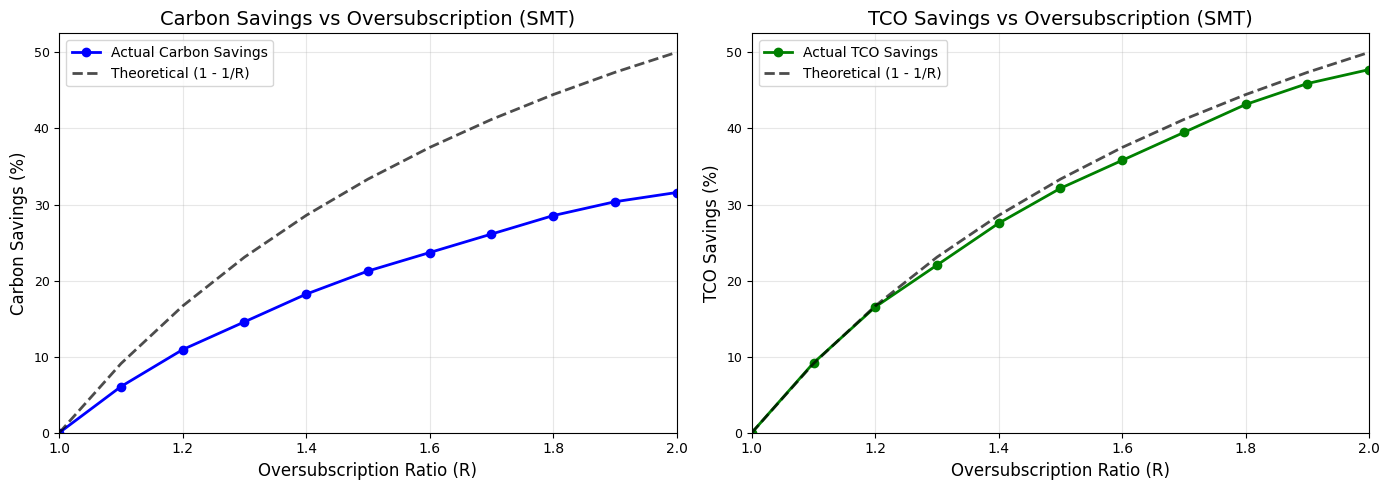

In [15]:
# Plot the results
fig = plot_oversub_savings_sweep(sweep, " (SMT)")

### Impact of Utilization Overhead

When oversubscribing, there's often additional overhead (context switching, scheduler inefficiency).
Let's see how a 5% utilization overhead affects the savings curve.

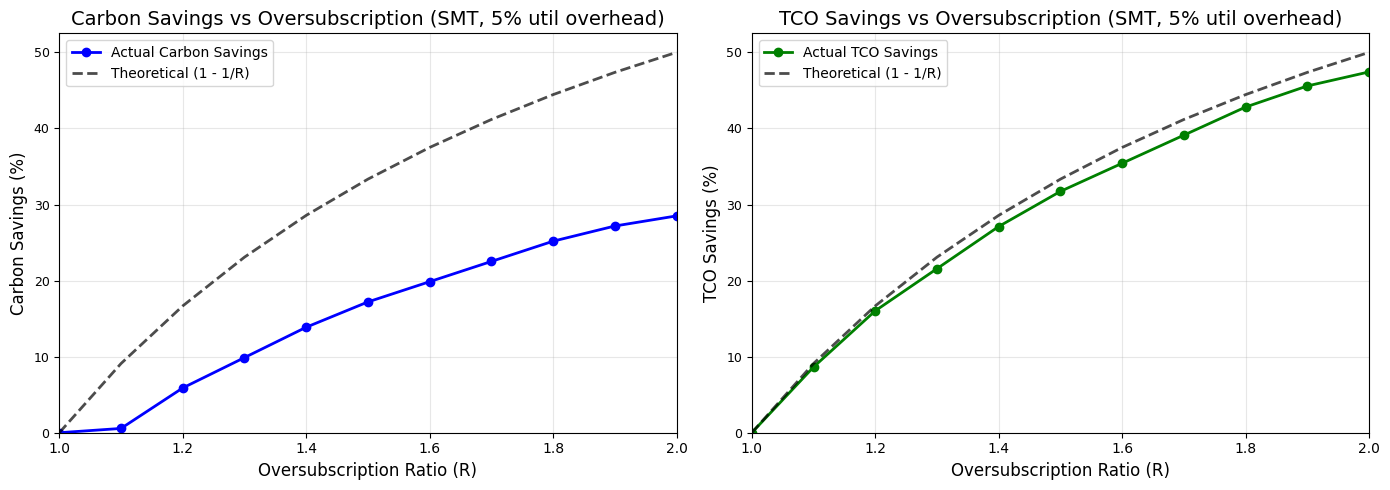

In [16]:
# Run the sweep WITH utilization overhead
sweep_with_overhead = compute_oversub_savings_sweep(
    total_vcpus=10000,
    avg_util=0.3,
    oversub_min=1.0,
    oversub_max=2.0,
    step=0.1,
    util_overhead=0.05,  # 5% additional overhead
    smt=True,
)

# Plot comparison
fig = plot_oversub_savings_sweep(sweep_with_overhead, " (SMT, 5% util overhead)")

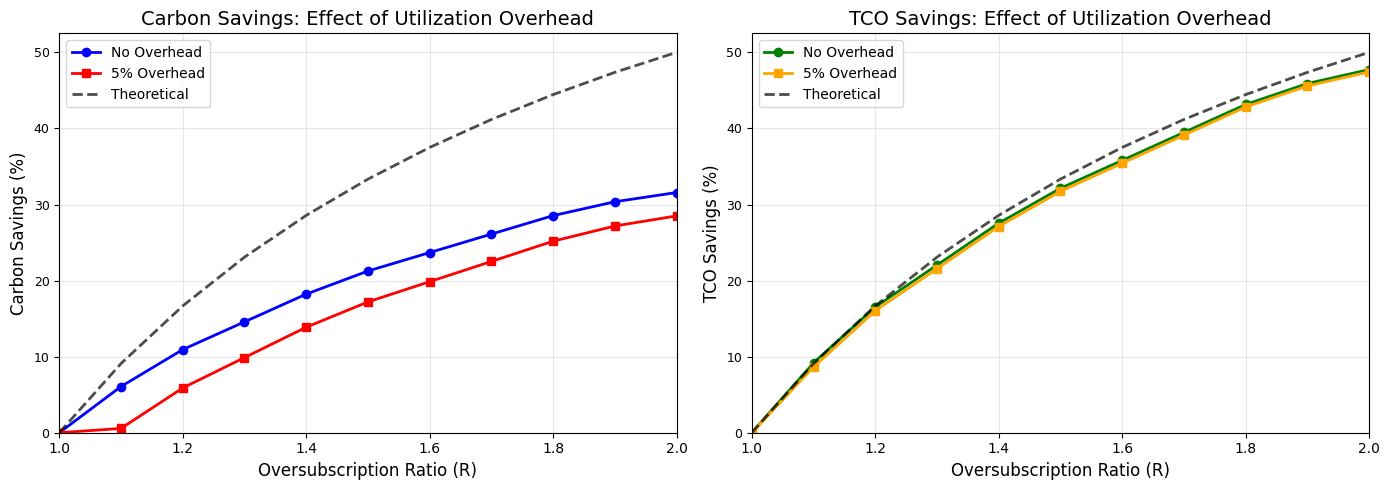

In [17]:
# Overlay both scenarios for comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ratios = sweep['ratios']

# Carbon savings comparison
ax1 = axes[0]
ax1.plot(ratios, sweep['carbon_savings_pct'], 'b-o', linewidth=2, markersize=6, label='No Overhead')
ax1.plot(ratios, sweep_with_overhead['carbon_savings_pct'], 'r-s', linewidth=2, markersize=6, label='5% Overhead')
ax1.plot(ratios, sweep['theoretical_savings_pct'], 'k--', linewidth=2, alpha=0.7, label='Theoretical')
ax1.set_xlabel('Oversubscription Ratio (R)', fontsize=12)
ax1.set_ylabel('Carbon Savings (%)', fontsize=12)
ax1.set_title('Carbon Savings: Effect of Utilization Overhead', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(ratios[0], ratios[-1])
ax1.set_ylim(bottom=0)

# TCO savings comparison
ax2 = axes[1]
ax2.plot(ratios, sweep['tco_savings_pct'], 'g-o', linewidth=2, markersize=6, label='No Overhead')
ax2.plot(ratios, sweep_with_overhead['tco_savings_pct'], 'orange', marker='s', linewidth=2, markersize=6, label='5% Overhead')
ax2.plot(ratios, sweep['theoretical_savings_pct'], 'k--', linewidth=2, alpha=0.7, label='Theoretical')
ax2.set_xlabel('Oversubscription Ratio (R)', fontsize=12)
ax2.set_ylabel('TCO Savings (%)', fontsize=12)
ax2.set_title('TCO Savings: Effect of Utilization Overhead', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(ratios[0], ratios[-1])
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()